In [40]:
import scipy.io
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model


## Data Loading and Processing

In [2]:
# data loading
data = scipy.io.loadmat('data/x.mat')
columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(data['x'].shape[1]) for j in range(data['x'].shape[2])])
data['x'].shape
labels = pd.read_csv("data/table_withlabels.csv")
foof = pd.read_csv("data/foof2features.csv")
beh = pd.read_csv("data/behaviorals.csv")
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
df.columns = columns
df['IDs'] = foof['C1']
df = pd.merge(df, labels[['label', 'IDs']], on='IDs', how='inner')
print(df['label'].value_counts())

Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


In [24]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [4]:
# data splitting

train_df, test_df = train_test_split(df, test_size=0.3)

train_labels, test_labels = train_df['label'], test_df['label']-1
train_labels_categorical, test_labels_categorical = to_categorical(train_df['label']-1), to_categorical(test_df['label']-1)

train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]

## AutoEncoder for Feature Extraction

In [ ]:
n_inputs = train_features.shape[1]

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# plot loss
#pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
#pyplot.legend()
#pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'data/encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('data/autoencoder.h5')

## Dealing with imbalance

In [6]:
oversample = SMOTE()
train_features_oversampled, train_labels_oversampled = oversample.fit_resample(train_features, train_labels)

## Linear Models

### SVC

In [23]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(train_features_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features)

Accuracy: 0.17537313432835822
Precision: 0.17537313432835822
Recall: 0.17537313432835822
F1 score: 0.17537313432835822


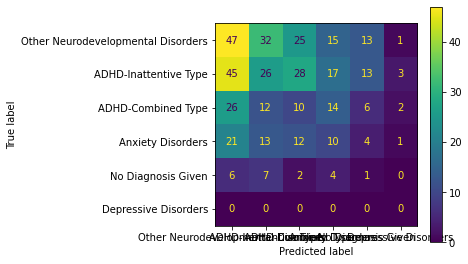

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True):
    
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='micro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='micro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='micro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(test_labels, predicted_labels_svc, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()

evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000))

clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features)

/home/anujanegi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anujanegi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anujanegi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/anujanegi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


KeyboardInterrupt: 

In [ ]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [ ]:
clf = OneVsOneClassifier(LinearSVC(random_state=0))

clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features)

In [ ]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features)

In [ ]:
evaluate(test_labels, predicted_labels_rf)